## 0. Importing Necessary Libraries & Dependencies

In [4]:
# Importing libraries
import torch
from torch import nn

# Setting up device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current Device: {device}")

Current Device: cpu


## 1. Getting Data

In [5]:
import requests
import zipfile
from pathlib import Path

# Setup data path for the data folder
data_path = Path("data/")
image_data_path = data_path / "rock_paper_scissor"

# If the rock_paper_scissors folder doesn't exists, download and prepare it...
if image_data_path.is_dir():
  print(f"rock_paper_scissor already exists! Skipping download.......")
else:
  print(f"rock_paper_scissor doesn't exists. Creating one.......")
  image_data_path.mkdir(parents=True, exist_ok=True)

  # Download rock_paper_scissors contents
  with open(data_path / "rock_paper_scissors.zip", "wb") as f:
    request = requests.get("https://github.com/nepal-manjil32/pytorch-models/raw/main/datasets/rock_paper_scissors.zip")
    print(f"Downloading rock_paper_scissors.........")
    f.write(request.content)

  # Unzip rock_paper_scissors
  with zipfile.ZipFile(data_path / "rock_paper_scissors.zip", "r") as zip_ref:
    print("Unzipping rock_paper_scissors.zip...")
    zip_ref.extractall(image_data_path)

rock_paper_scissor already exists! Skipping download.......


## 2. Data Preparation

In [6]:
###-- Let's see the structure of our data folder --###
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}.")

walk_through_dir(data_path)

There are 1 directories and 1 images in 'data.
There are 3 directories and 2 images in 'data/rock_paper_scissor.
There are 3 directories and 0 images in 'data/rock_paper_scissor/train.
There are 0 directories and 840 images in 'data/rock_paper_scissor/train/scissors.
There are 0 directories and 840 images in 'data/rock_paper_scissor/train/rock.
There are 0 directories and 840 images in 'data/rock_paper_scissor/train/paper.
There are 3 directories and 0 images in 'data/rock_paper_scissor/valid.
There are 0 directories and 124 images in 'data/rock_paper_scissor/valid/scissors.
There are 0 directories and 124 images in 'data/rock_paper_scissor/valid/rock.
There are 0 directories and 124 images in 'data/rock_paper_scissor/valid/paper.
There are 3 directories and 0 images in 'data/rock_paper_scissor/test.
There are 0 directories and 11 images in 'data/rock_paper_scissor/test/scissors.
There are 0 directories and 11 images in 'data/rock_paper_scissor/test/rock.
There are 0 directories and 11

In [7]:
###-- Setup training and testing paths --###
train_dir = image_data_path / "train"
test_dir = image_data_path / "test"

print(f"Training data path: {train_dir}")
print(f"Testing data path: {test_dir}")

Training data path: data/rock_paper_scissor/train
Testing data path: data/rock_paper_scissor/test


### 2.1 Visualize an Image

Random image path: data/rock_paper_scissor/valid/scissors/testscissors04-00_png.rf.b50b207054d6626a3d70694b11326004.jpg
Random image class: scissors
Random image height: 300
Random image width: 300


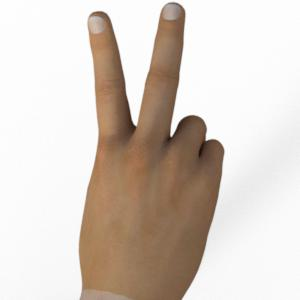

In [8]:
###-- Visualizing using PIL --###
import random
from PIL import Image
random.seed(42)

# List out all the images path (both training and testing images)
image_path_list = list(image_data_path.glob("*/*/*.jpg"))

# Select a random image path
random_image_path = random.choice(image_path_list)
print(f"Random image path: {random_image_path}")

# Get the random image class from path name (image class is same as the name of the directory of the image)
random_image_class = random_image_path.parent.stem
print(f"Random image class: {random_image_class}")

# Open the random image
img = Image.open(random_image_path)
print(f"Random image height: {img.height}")
print(f"Random image width: {img.width}")
img

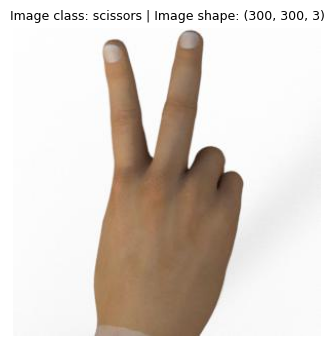

In [9]:
###-- Visualizing using matplotlib --###
import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array
image_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(5,4))
plt.imshow(image_array)
plt.title(f"Image class: {random_image_class} | Image shape: {image_array.shape}", fontsize=9) # -> [height, width, color_channels]
plt.axis(False)
plt.show()

## 3. Transforming Data

Before we train our model with the images we have, we need to convert these images into:
1. `tensors` (numerical representation of our images).
2. `torch.utils.data.Dataset` (Dataset) and subsequently a `torch.utils.data.DataLoader` (DataLoader)

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming Images Using `torchvision.transforms`

In [11]:
# Code for image transformation
image_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

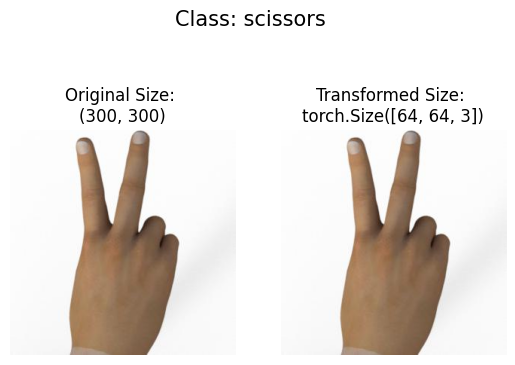

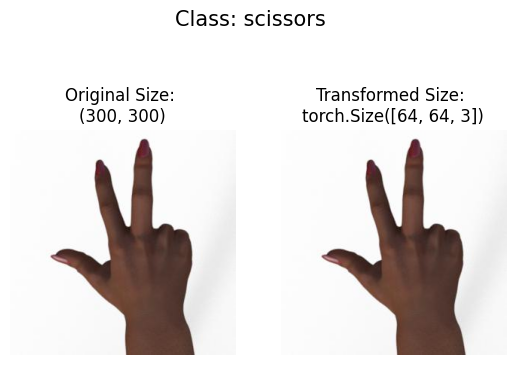

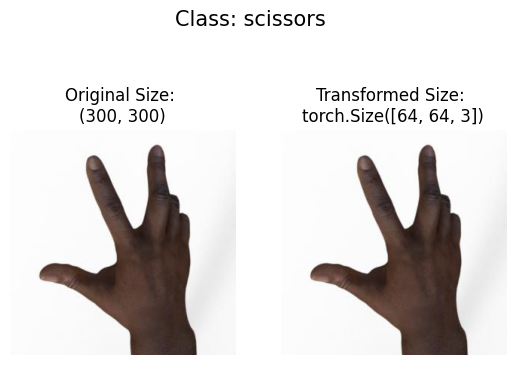

In [12]:
###-- Let's plot some transfomed images --###
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      # Plot original image
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original Size: \n{f.size}")
      ax[0].axis(False)

      # Plot transformed image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(f)
      ax[1].set_title(f"Transformed Size: \n{transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=15)

plot_transformed_images(image_path_list, image_transform, n=3, seed=42)

## 4. Loading Image Data Using `ImageFolder`

Since our image data is in the standard image classification format, we can use the class `torchvision.datasets.ImageFolder`.

In [13]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=train_dir,
                         transform=image_transform,
                         target_transform=None)

test_data = ImageFolder(root=test_dir,
                         transform=image_transform)

print(f"Train Data: {train_data}")
print(f"Test Data: {test_data}")

Train Data: Dataset ImageFolder
    Number of datapoints: 2520
    Root location: data/rock_paper_scissor/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data: Dataset ImageFolder
    Number of datapoints: 33
    Root location: data/rock_paper_scissor/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
# Get the class names as a list
class_names = train_data.classes
class_names

['paper', 'rock', 'scissors']

In [15]:
# Get class names a dictionary
class_dict = train_data.class_to_idx
class_dict

{'paper': 0, 'rock': 1, 'scissors': 2}

In [16]:
print(f"Length of train_data: {len(train_data)}")
print(f"Length of test_data: {len(test_data)}")

Length of train_data: 2520
Length of test_data: 33


In [17]:
##-- Let's see one of the training images
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor: {img}\n")
print(f"Image Shape: {img.shape}")
print(f"Image DataType: {type(img)}")
print(f"Image Label: {label}")

Image Tensor: tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.00

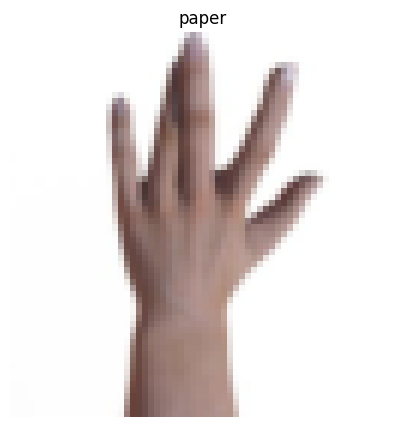

In [18]:
##-- Let's plot the above image
plt.figure(figsize=(6,5))
plt.imshow(img.permute(1,2,0))
plt.axis(False)
plt.title(f"{class_names[label]}")
plt.show()

## 5. Turn Loaded Images Into `DataLoaders`

In [19]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

print(f"NUM_WORKERS: {NUM_WORKERS}")

NUM_WORKERS: 2


In [20]:
print(f"Train DataLoader: {train_dataloader}")
print(f"Test DataLoader: {test_dataloader}")

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7db3ee298580>
Test DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7db3ee299ae0>


In [21]:
###-- Let's see the first image of our train_dataloader
img, label = next(iter(train_dataloader)) # return a batch of 32 images (or whatever number you set as the batch size).
print(f"Image: {img}")
print(f"Image Shape: {img.shape} -> [batch_size, color_channels, height widht]")
print(f"Label: {label}")
print(f"Label Shape: {label.shape}")

Image: tensor([[[[0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9882, 0.9882],
          [0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9882, 0.9882],
          [0.9961, 0.9961, 0.9922,  ..., 0.9882, 0.9882, 0.9843],
          ...,
          [0.9843, 0.9843, 0.9843,  ..., 0.9725, 0.9725, 0.9765],
          [0.9843, 0.9843, 0.9843,  ..., 0.9725, 0.9725, 0.9765],
          [0.9882, 0.9882, 0.9843,  ..., 0.9725, 0.9725, 0.9686]],

         [[0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9882, 0.9882],
          [0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9882, 0.9882],
          [0.9961, 0.9961, 0.9922,  ..., 0.9882, 0.9882, 0.9843],
          ...,
          [0.9843, 0.9843, 0.9843,  ..., 0.9725, 0.9725, 0.9765],
          [0.9843, 0.9843, 0.9843,  ..., 0.9725, 0.9725, 0.9765],
          [0.9882, 0.9882, 0.9843,  ..., 0.9725, 0.9725, 0.9686]],

         [[0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9882, 0.9882],
          [0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9882, 0.9882],
          [0.9961, 0.9961, 0.9922, 

## 6. TinyVGG Model

<img src="https://miro.medium.com/v2/resize:fit:1400/1*3ZkXJ-nIajuY3iX27w12aw.png" width="60%" />

In [22]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model_0 = TinyVGG(input_shape=3, # no of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 6.1 Using `torchinfo` For Model Visualization

In [23]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

In [24]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [25]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [26]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [27]:
# Set random seeds
#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0082 | train_acc: 0.4644 | test_loss: 1.1355 | test_acc: 0.2969
Epoch: 2 | train_loss: 0.4044 | train_acc: 0.8521 | test_loss: 0.3776 | test_acc: 0.8750
Epoch: 3 | train_loss: 0.1336 | train_acc: 0.9581 | test_loss: 0.2183 | test_acc: 0.9062
Epoch: 4 | train_loss: 0.0634 | train_acc: 0.9854 | test_loss: 0.2765 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.0440 | train_acc: 0.9885 | test_loss: 0.1818 | test_acc: 0.9531
Epoch: 6 | train_loss: 0.0404 | train_acc: 0.9901 | test_loss: 0.1444 | test_acc: 0.9531
Epoch: 7 | train_loss: 0.0333 | train_acc: 0.9921 | test_loss: 0.2731 | test_acc: 0.9219
Epoch: 8 | train_loss: 0.0130 | train_acc: 0.9964 | test_loss: 0.1074 | test_acc: 0.9375
Epoch: 9 | train_loss: 0.0153 | train_acc: 0.9960 | test_loss: 0.0297 | test_acc: 0.9844
Epoch: 10 | train_loss: 0.0104 | train_acc: 0.9968 | test_loss: 0.2308 | test_acc: 0.8906
Total training time: 141.008 seconds


In [28]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [29]:
def plot_loss_curves(results: dict[str, list[float]]):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

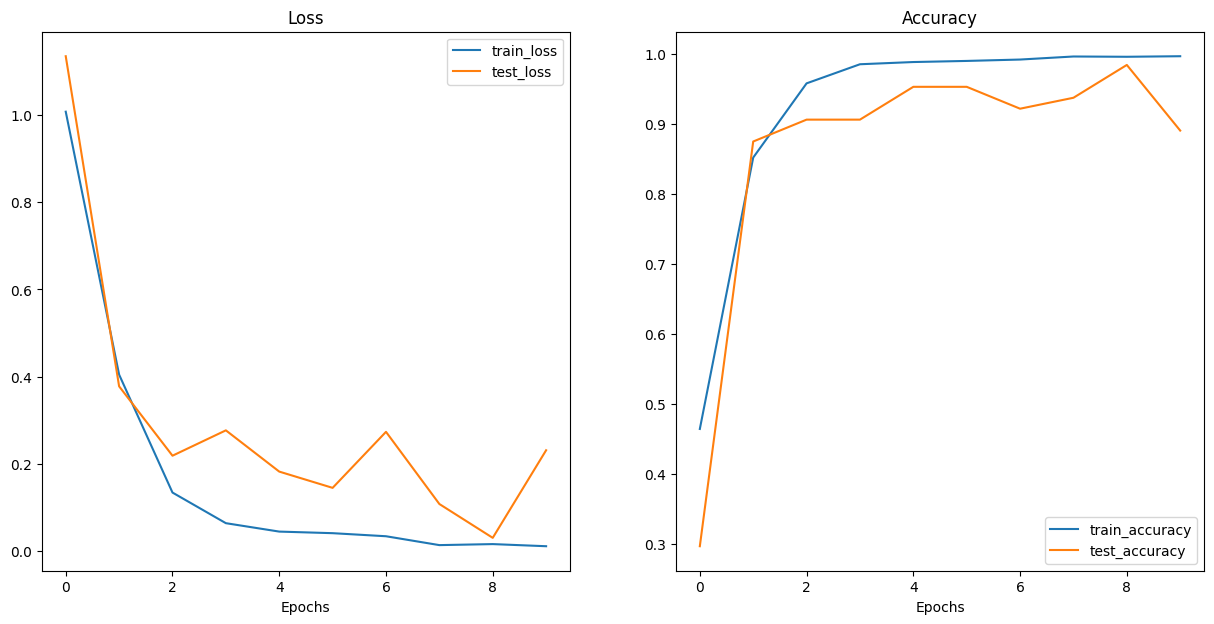

In [30]:
plot_loss_curves(model_0_results)